In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score


In [7]:
df = pd.read_csv("IMDb Movies India.csv",encoding='latin1')
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [17]:
# Drop rows with missing Rating (target variable)
df.dropna(subset=["Rating"], inplace=True)
# Convert to string first, then remove ' min' and convert to float
df["Duration"] = df["Duration"].astype(str).str.replace(' min', '', regex=False)
df["Duration"] = pd.to_numeric(df["Duration"], errors='coerce')

# Fill missing Duration with median
df["Duration"] = df["Duration"].fillna(df["Duration"].median())
# First, convert 'Votes' to numeric, removing commas if present
df["Votes"] = df["Votes"].astype(str).str.replace(',', '')
df["Votes"] = pd.to_numeric(df["Votes"], errors='coerce')

# Now fill missing values with the median
df["Votes"] = df["Votes"].fillna(df["Votes"].median())

df["Director"] = df["Director"].fillna(df["Director"].mode()[0])
df["Actor 1"] = df["Actor 1"].fillna(df["Actor 1"].mode()[0])
df["Actor 2"] = df["Actor 2"].fillna(df["Actor 2"].mode()[0])
df["Actor 3"] = df["Actor 3"].fillna(df["Actor 3"].mode()[0])
df["Genre"] = df["Genre"].fillna("Unknown")


In [33]:
# Extract first genre
df["Main Genre"] = df["Genre"].apply(lambda x: x.split(",")[0])

# One-hot encoding of categorical features
categorical_features = ["Main Genre", "Director", "Actor 1"]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Combine features
numerical = df[["Duration", "Votes"]].reset_index(drop=True)
X = pd.concat([numerical, encoded_df], axis=1)
y = df["Rating"].reset_index(drop=True)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [39]:
# Prediction & Evaluation
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: -0.003478247965131631
RMSE: 1.365873972387226


In [41]:
best_year = df.groupby("Year")["Rating"].mean().idxmax()
best_rating = df.groupby("Year")["Rating"].mean().max()
print("Best Year:", best_year, "with Rating:", round(best_rating, 2))


Best Year: (1948) with Rating: 7.07


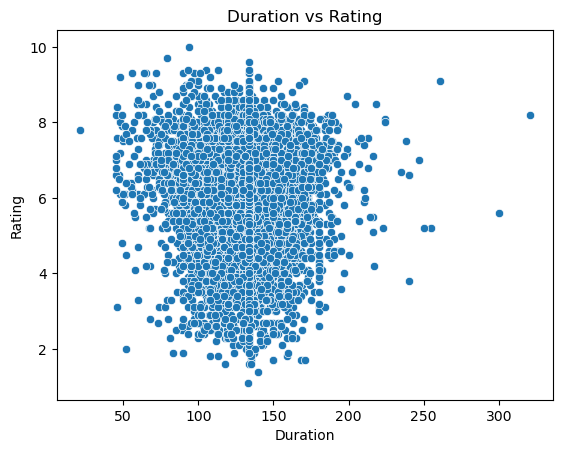

In [43]:
sns.scatterplot(x=df["Duration"], y=df["Rating"])
plt.title("Duration vs Rating")
plt.show()


In [72]:
# Top 10 Overall
top10_overall = df.sort_values("Rating", ascending=False)[["Name", "Rating"]].head(10)
print("Top 10 Movies Overall:")
print(top10_overall)

# Top 10 per year without using apply, using groupby().head() directly
top10_per_year = (
    df.sort_values("Rating", ascending=False)
    .groupby("Year", group_keys=False)  # Ensure group_keys=False to avoid including 'Year' as a group column
    .head(10)  # This grabs the top 10 rows per group (per year)
)

# Reset the index if necessary to clean up the result
top10_per_year.reset_index(drop=True, inplace=True)
print("Top 10 Movies per Year:")
print(top10_per_year[["Year", "Name", "Rating"]])


Top 10 Movies Overall:
                      Name  Rating
8339       Love Qubool Hai    10.0
5410            Half Songs     9.7
2563                 Breed     9.6
11704             Ram-Path     9.4
14222  The Reluctant Crime     9.4
6852                  June     9.4
5077          Gho Gho Rani     9.4
1314          Ashok Vatika     9.3
5125           God of gods     9.3
12673   Secrets of Sinauli     9.3
Top 10 Movies per Year:
       Year                 Name  Rating
0    (2020)      Love Qubool Hai    10.0
1    (2021)           Half Songs     9.7
2    (2020)                Breed     9.6
3    (2017)             Ram-Path     9.4
4    (2020)  The Reluctant Crime     9.4
..      ...                  ...     ...
874  (1939)           Kala Jigar     3.3
875  (1936)        Rajput Ramani     3.1
876  (1936)       Jungle Ki Rani     2.8
877  (1933)            Abe Hayat     2.8
878  (1934)           Piya Pyare     2.7

[879 rows x 3 columns]


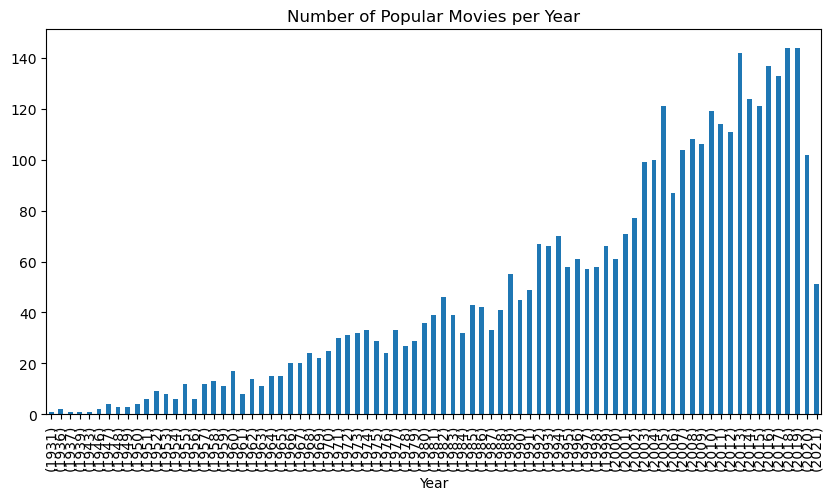

In [64]:
popular_movies_year = df[df["Votes"] > df["Votes"].median()].groupby("Year").size()
popular_movies_year.plot(kind="bar", figsize=(10,5))
plt.title("Number of Popular Movies per Year")
plt.show()


In [74]:
top_voted = df.sort_values(["Votes", "Rating"], ascending=False)[["Name", "Votes", "Rating"]].head(10)
print("Top Voted Movies with High Ratings:")
print(top_voted)



Top Voted Movies with High Ratings:
                         Name   Votes  Rating
8219               Life of Pi  591417     7.9
75                   3 Idiots  357889     8.4
8233                     Lion  220526     8.0
4848                   Gandhi  220118     8.0
14038  The Darjeeling Limited  185127     7.2
8228      Like Stars on Earth  175810     8.4
10882                      PK  168150     8.1
3410                   Dangal  165074     8.4
11463                   Radhe  162455     1.8
3829              Dil Bechara  117377     6.6


In [68]:
most_movies_director = df["Director"].value_counts().idxmax()
director_count = df["Director"].value_counts().max()
print(f"Most Active Director: {most_movies_director} with {director_count} movies")


Most Active Director: Mahesh Bhatt with 52 movies


In [70]:
actors = pd.concat([df["Actor 1"], df["Actor 2"], df["Actor 3"]])
most_common_actor = actors.value_counts().idxmax()
actor_count = actors.value_counts().max()
print(f"Most Featured Actor: {most_common_actor} in {actor_count} movies")


Most Featured Actor: Pran in 377 movies


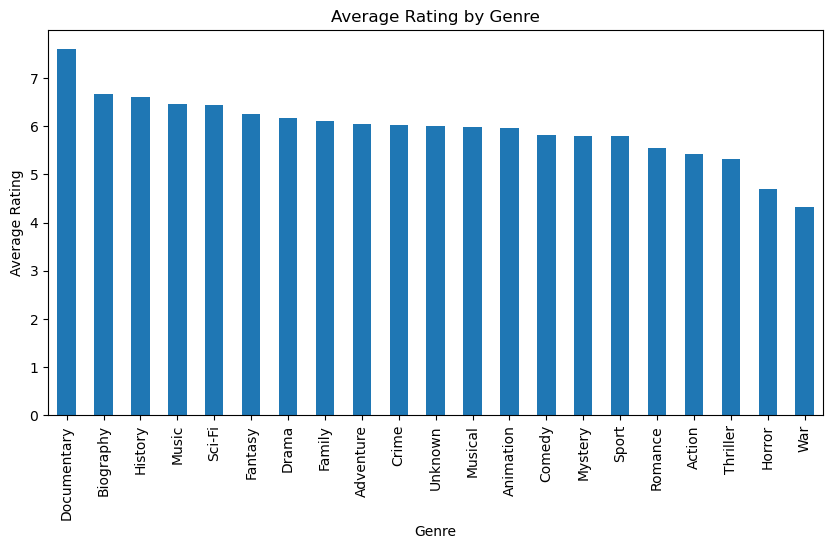

In [76]:
genre_ratings = df.groupby("Main Genre")["Rating"].mean()
genre_ratings.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()


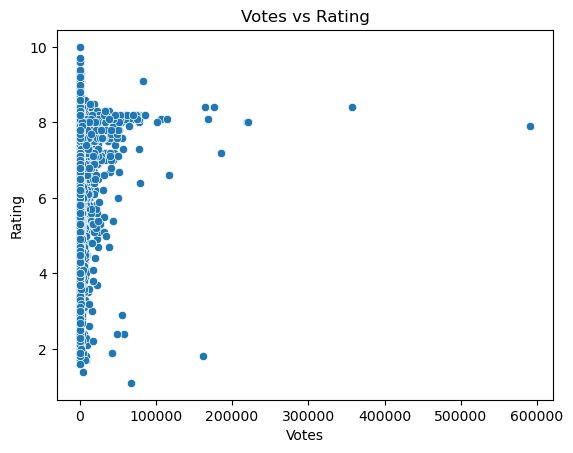

In [78]:
sns.scatterplot(x=df["Votes"], y=df["Rating"])
plt.title("Votes vs Rating")
plt.xlabel("Votes")
plt.ylabel("Rating")
plt.show()
